<a href="https://colab.research.google.com/github/u6yuvi/Algorithms/blob/main/ml_design/Youtube_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [74]:
from pathlib import Path
from tqdm import tqdm_notebook
from copy import deepcopy

In [6]:
DIR_PATH = Path("/content/drive/MyDrive/Analytics/models/yt_recom")

# Download Movie Lens Dataset

[Link](https://grouplens.org/datasets/movielens/100k/)

In [7]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2023-03-06 08:17:17--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.5MB/s    in 0.3s    

2023-03-06 08:17:17 (16.5 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [8]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [11]:
import pandas as pd
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
!ls

drive  ml-100k	ml-100k.zip  sample_data


In [16]:
data_path = "ml-100k/"
id_val = 1
num_users = 943 
num_items = 1682 
train_dataframe = pd.read_csv(f'{data_path}u{id_val}.base',sep='\t',header=None)
train_dataframe.columns = ['user_id','item_id','rating','ts']
train_dataframe['user_id'] = train_dataframe['user_id'] -1 
train_dataframe['item_id'] = train_dataframe['item_id'] -1
valid_df = pd.read_csv(f'{data_path}u{id_val}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1 
valid_df['item_id'] = valid_df['item_id'] -1
train_dataframe.shape, valid_df.shape

((80000, 4), (20000, 4))

In [20]:
train_dataframe.head()

,user_id,item_id,rating,ts
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712


In [23]:
train_dataframe[train_dataframe.user_id==0].item_id.nunique()

135

In [29]:
train_dataframe.groupby("user_id")["item_id"].agg(len).describe()

count    943.000000
mean      84.835631
std       83.806416
min        4.000000
25%       27.000000
50%       50.000000
75%      115.000000
max      685.000000
Name: item_id, dtype: float64

In [17]:
train_usrs = train_dataframe.user_id.unique()
vald_usrs = valid_df.user_id.unique()
len(train_usrs),len(vald_usrs)


(943, 459)

In [18]:
train_itms = train_dataframe.item_id.unique()
vald_itms = valid_df.item_id.unique()
len(train_itms),len(vald_itms)

(1650, 1410)

In [34]:
class MovieDataset:
  def __init__(self, df, user_col = 0, item_col =1, rating_col = 2 ):
    self.df = df
    self.user_tensor = torch.tensor(df.iloc[:,user_col],dtype=torch.long, device=device)
    self.item_tensor = torch.tensor(df.iloc[:,item_col],dtype = torch.long,device = device)
    self.rating_tensor = torch.tensor(df.iloc[:,rating_col],dtype=torch.long,device = device)

  def __getitem__(self,index):
    return self.user_tensor[index],self.item_tensor[index],self.rating_tensor[index]

  def __len__(self):
    return (self.user_tensor.shape[0])

batch_size = 2000
train_dataset = MovieDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = MovieDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [33]:
next(iter(train_dataloader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([749, 405, 268,  ..., 486, 901, 711]),
 tensor([329, 152, 121,  ...,  93, 171,  68]),
 tensor([2, 3, 1,  ..., 3, 4, 3])]

In [45]:
class Recommender(nn.Module):
  def __init__(self,config):
    super(Recommender,self).__init__()

    self.config = config
    self.num_users = config['num_users']
    self.num_items = config['num_items']
    self.emb_size = config['emb_size']
    self.emb_droupout = config['emb_droupout']
    self.fc_layer_sizes = config['fc_layer_sizes']
    self.dropout = config['dropout']
    self.out_range = config['out_range']

    self.embed_user = nn.Sequential(nn.Embedding(num_embeddings=self.num_users,embedding_dim=self.emb_size),\
                                    nn.Dropout(p = self.emb_droupout))
    self.embed_item = nn.Sequential(nn.Embedding(num_embeddings=self.num_items,embedding_dim=self.emb_size),\
                                    nn.Dropout(p = self.emb_droupout))

    #fully connected layer

    fc_layers_list = []
    for fc_i , fc_o , fc_drop in zip(self.fc_layer_sizes[:-1],self.fc_layer_sizes[1:],self.dropout):
      fc_layers_list.append(nn.Linear(fc_i,fc_o))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(fc_o))
      fc_layers_list.append(nn.Dropout(fc_drop))

    self.fc_layers = nn.Sequential(*fc_layers_list)

    #output_head

    self.output = nn.Linear(self.fc_layer_sizes[-1],1)

  def forward(self,user_idx,item_idx):
    user_embed = self.embed_user(user_idx)
    item_embed = self.embed_item(item_idx)
    user_item = torch.concat([user_embed,item_embed],axis=1)
    fc1 = self.fc_layers(user_item)
    fc_out = torch.sigmoid(self.output(fc1))
    fc_out = fc_out * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
    return fc_out

config = {
    'num_users':943, 
    'num_items':1682, 
    'emb_size':50, 
    'emb_droupout': 0.05, 
    'fc_layer_sizes': [100, 512, 256], 
    'dropout': [0.7,0.35], 
    'out_range': [0.8,5.2]} 
model = Recommender(config)
model

      
      
    
      

Recommender(
  (embed_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (embed_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

In [46]:
batch_size = 2000 
learning_rate = 1e-2 
weight_decay = 5e-1 
num_epoch = 100 
reduce_learning_rate = 1 
early_stoping = 5 
 
 
learning_rates = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None
 
train_dataset = MovieDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = MovieDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
 
 
model = Recommender(config)
criterion = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(),lr = learning_rate, betas=(0.9,0.999), weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-3,
                                                       patience=reduce_learning_rate, min_lr=learning_rate/10)

In [75]:
for e in tqdm_notebook(range(num_epoch)): 
    model.train()
    train_loss = 0
    for u,i,r in train_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        
        loss = criterion(r_pred,r.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    current_learning_rate = scheduler.optimizer.param_groups[0]["lr"]
    learning_rates.append(current_learning_rate)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        loss = criterion(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_dataset)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_learning_rate}')
 
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1
 
    if no_improvements >= early_stoping:
        print(f'early stopping after epoch {e}')
        break
    
    scheduler.step(valid_loss)

<ipython-input-75-db2937637616>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(num_epoch)):


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 Train loss: 0.9220582336425781; Valid loss: 0.9469948852539063; Learning rate: 0.01
Epoch 1 Train loss: 0.8997816009521484; Valid loss: 0.937365380859375; Learning rate: 0.01
Epoch 2 Train loss: 0.881340493774414; Valid loss: 0.92452275390625; Learning rate: 0.01
Epoch 3 Train loss: 0.8712973022460937; Valid loss: 0.91058994140625; Learning rate: 0.01
Epoch 4 Train loss: 0.864230290222168; Valid loss: 0.9138363037109375; Learning rate: 0.01
Epoch 5 Train loss: 0.8562354858398438; Valid loss: 0.9040654968261719; Learning rate: 0.01
Epoch 6 Train loss: 0.8489992340087891; Valid loss: 0.8931829772949219; Learning rate: 0.01
Epoch 7 Train loss: 0.8379742630004883; Valid loss: 0.8942795837402344; Learning rate: 0.01
Epoch 8 Train loss: 0.8265553985595703; Valid loss: 0.8777992797851563; Learning rate: 0.01
Epoch 9 Train loss: 0.8217594802856445; Valid loss: 0.8767254455566407; Learning rate: 0.01
Epoch 10 Train loss: 0.8123458801269531; Valid loss: 0.8722957946777343; Learning rate:

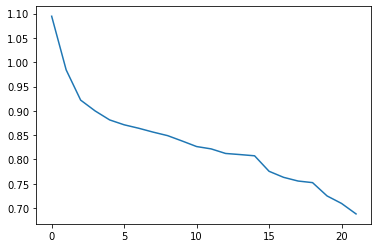

In [78]:
from matplotlib import pyplot as plt
plt.plot(train_losses)


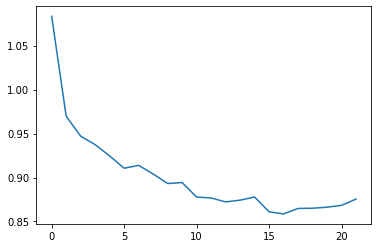

In [79]:
plt.plot(valid_losses)